### Researched Quantities

- Building this model based on a 10-year rainstorm, which is 5.5 inches in 24 hours.
-Here is the link to the sheet with the data about the plants https://1drv.ms/x/c/348b84fad346e9f1/EX-eKXt_eg1HnNybvuDh2aUBIBjV-u4fKmu33ILq_tpZVw?e=BLTTLG 
- Unit conversions:
    - 1 square mile = 640 acres
    - 1 square mile = 27,878,400 square feet
    - 1 foot = 12 inches
    - 1 gallon = 0.13368 cubic feet
- According to HomeAdvisor, it costs between $50 to $250 per linear foot to insall a sewer line. I feel like since it's NYC it'll be more expensive but it's so much that they can probably get pretty good pricing so I'm just going to guess $150 per linear foot.
    https://www.homeadvisor.com/cost/plumbing/install-a-sewer-main/
- according to NYC waterboards, the sewer rate $7.14 / 100 ft^3 = $9544.79 $/ MG in 2024: https://www.nyc.gov/site/nycwaterboard/rates/rates-regulations.page

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables
Pkg.add("XLSX")

  Activating project at `~/Documents/Programming/Julia/BEE4750/4750project`
   Resolving package versions...
  No Changes to `~/Documents/Programming/Julia/BEE4750/4750project/Project.toml`
  No Changes to `~/Documents/Programming/Julia/BEE4750/4750project/Manifest.toml`


In [2]:
#deriving objective function
import XLSX
data = XLSX.readxlsx("WWTP_data.xlsx")

facilities = data["Sheet1!A2:A15"]
design_capacity = data["Sheet1!B2:B15"]
population_served = data["Sheet1!C2:C15"] #BASE CONDITION
sanitary_demand = 80*(10^-6)*population_served #MGD = (gal/(day* person)) * people * 10^-6 MGD/(gal/d)

cost_per_mile = 150*5280 #$/ft * ft/mile
distance = data["Sheet1!E2:E15"] #BASE CONDITION
W_coef = distance*cost_per_mile

#rainfall amoutns to input into model:

# storm_height = 5.5/12 #feet / day for 10 year storm
# storm_height = .85/12 #feet / day for ALL ABOVE capacity
# storm_height = 0.06/12 #feet / day example for ALL BELOW capacity 
storm_height = 0.3/12 #feet / day for most but not all over #BASE CONDITION

drainage_area = data["Sheet1!D2:D15"] #acres = (miles^2)/640
storm_vol = (storm_height * drainage_area)/3.06888 #MGD = ((in/day)*acre)/(3.06888 acre foot / Mgal)
treatment_cost = 9544.79 #dollars / MGD 
# CSO_cost = 1_500_000; #dollars/Mgal # incorrect (old) BASE CONDITION
CSO_cost = 200_000; #corrected base condition

In [3]:
#Setting Up Optimization
stormwater_model = Model(HiGHS.Optimizer) #initialize model object

#create variables: does each plant divert stormwater  to new plant or allow a CSO
@variable(stormwater_model, C[1:14], Bin) #are we over capacity?
@variable(stormwater_model, 0<= Q[1:14] <= 100000) #how much water will go to the new plant
@variable(stormwater_model, O[1:14] >= 0) #how much will CSO
@variable(stormwater_model, W[1:14], Bin) #do we build connections to the new plant?

#create objective function
@objective(stormwater_model, Min, sum(W_coef .* W) + sum(treatment_cost .* Q) + sum(CSO_cost .* O))

#constraints
for i in 1:14
    @constraint(stormwater_model, !C[i] => {storm_vol[i] + sanitary_demand[i] <= design_capacity[i]})
    @constraint(stormwater_model, !W[i] => {Q[i] == 0})
    @constraint(stormwater_model, Q[i] + O[i] == C[i]*(storm_vol[i] + sanitary_demand[i] - design_capacity[i]))
end

In [4]:
#optimize
optimize!(stormwater_model)
@show value.(C)
@show value.(W)
@show value.(Q)
@show value.(O)
@show objective_value(stormwater_model);

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+05]
  Cost   [1e+04, 1e+07]
  Bound  [1e+00, 1e+05]
  RHS    [9e+00, 2e+02]
Presolving model
16 rows, 24 cols, 32 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve: Optimal

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   60531040.25575  60531040.25575     0.00%        0      0      0         0     0.0s

Solving report
  Status            Optimal
 

In [5]:
W = value.(W)
Q = value.(Q)
O = value.(O)
C = value.(C)

# Calculate the contribution to the objective function for each plant (index)
cost_per_plant = []
cost_per_plant_Q = 0
for i in 1:14
    contrib = (W_coef[i] * W[i])  + (treatment_cost * Q[i]) + (CSO_cost * O[i])
    cost_per_plant_Q += (W_coef[i] * W[i])  + (treatment_cost * Q[i])
    push!(cost_per_plant, contrib)
end
    
storm_vol = vec(storm_vol)
plant_name = vec(facilities)
design_cap = vec(design_capacity)
sanitary_demand = vec(sanitary_demand)
table = DataFrame(Plant_Name = plant_name, Design_Capacity=design_cap, Sanitary_Demand=sanitary_demand, Storm_Vol=storm_vol, Over_Capacity=Bool.(C), Build_New=Bool.(W), Diverted_Flow=Q, CSO=O, Cost=cost_per_plant)
display(table)

#marginal cost (cost per gallon CSO avoided)
println("total cost = ", objective_value(stormwater_model))
print("marginal cost = ", (cost_per_plant_Q)/(sum(Q)*10^6))


Row,Plant_Name,Design_Capacity,Sanitary_Demand,Storm_Vol,Over_Capacity,Build_New,Diverted_Flow,CSO,Cost
,Any,Any,Float64,Float64,Bool,Bool,Float64,Float64,Any
1,26th Ward WRRF,85,22.6742,48.1202,false,false,0.0,0.0,0.0
2,Bowery Bay WRRF,150,67.8662,123.848,true,true,41.7144,0.0,7.96175e6
3,Coney Island WRRF,110,47.7061,122.903,true,true,60.6092,0.0,8.4985e6
4,Hunts Point WRRF,200,54.7655,135.75,false,false,0.0,0.0,0.0
5,Jamaica WRRF,100,58.2498,206.207,true,true,164.457,0.0,1.18657e7
6,Newtown Creek WRRF,310,85.441,127.538,false,false,0.0,0.0,0.0
7,North River WRRF,170,47.1018,49.1222,false,false,0.0,0.0,0.0
8,Oakwood Beach WRRF,39.9,19.5934,87.8089,true,true,67.5023,0.0,9.5543e6
9,Rockaway WRRF,45,7.23792,50.9877,true,false,0.0,13.2256,2.64512e6


total cost = 6.053104025574627e7
marginal cost = 0.11458266307743084

In [6]:
#adding plots
rainfall = range(start=0 , stop=1, step=0.04)
overflow_num = zeros(length(rainfall))
CSO_num = zeros(length(rainfall))
overflow_vol = zeros(length(rainfall))
divert_num = zeros(length(rainfall))
marginal_cost = zeros(length(rainfall))

for i in 1:length(rainfall)
    storm_height = rainfall[i]/12
    storm_vol = (storm_height * drainage_area)/3.06888

    #Setting Up Optimization
    stormwater_model = Model(HiGHS.Optimizer) #initialize model object

    #create variables: does each plant divert stormwater  to new plant or allow a CSO
    @variable(stormwater_model, C[1:14], Bin) #are we over capacity?
    @variable(stormwater_model, 0<= Q[1:14] <= 100000) #how much water will go to the new plant
    @variable(stormwater_model, O[1:14] >= 0) #how much will CSO
    @variable(stormwater_model, W[1:14], Bin) #do we build connections to the new plant?

    #create objective function
    @objective(stormwater_model, Min, sum(W_coef .* W) + sum(treatment_cost .* Q) + sum(CSO_cost .* O))

    #constraints
    for i in 1:14
        @constraint(stormwater_model, !C[i] => {storm_vol[i] + sanitary_demand[i] <= design_capacity[i]})
        @constraint(stormwater_model, !W[i] => {Q[i] == 0})
        @constraint(stormwater_model, Q[i] + O[i] == C[i]*(storm_vol[i] + sanitary_demand[i] - design_capacity[i]))
    end

    optimize!(stormwater_model)

    overflow_num[i] = (sum(value.(C)))
    divert_num[i] =  (sum(value.(W)))
    overflow_vol[i] =  sum(value.(Q)) +  sum(value.(O))

    W = value.(W)
    Q = value.(Q)
    O = value.(O)
    C = value.(C)

    # Calculate the contribution to the objective function for each plant (index)
    cost_per_plant = []
    cost_per_plant_Q = 0
    for i in 1:14
        contrib = (W_coef[i] * W[i])  + (treatment_cost * Q[i]) + (CSO_cost * O[i])
        cost_per_plant_Q += (W_coef[i] * W[i])  + (treatment_cost * Q[i])
        push!(cost_per_plant, contrib)
    end
    
    marginal_cost[i] = (cost_per_plant_Q)/(sum(Q)*10^6)
end

# divert_num
table = DataFrame(Rainfall=rainfall, Overflow=overflow_num, Diverted_Flow=divert_num, CSO=CSO_num)
display(table)

Row,Rainfall,Overflow,Diverted_Flow,CSO
,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0
2,0.04,0.0,0.0,0.0
3,0.08,2.0,0.0,0.0
4,0.12,3.0,0.0,0.0
5,0.16,4.0,1.0,0.0
6,0.2,7.0,1.0,0.0
7,0.24,8.0,4.0,0.0
8,0.28,8.0,6.0,0.0
9,0.32,8.0,7.0,0.0


Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+05]
  Cost   [1e+04, 1e+07]
  Bound  [1e+00, 1e+05]
  RHS    [2e+01, 2e+02]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve: Optimal

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               0                  0.00%        0      0      0         0     0.0s

Solving report
  Status            Optimal
  Pr

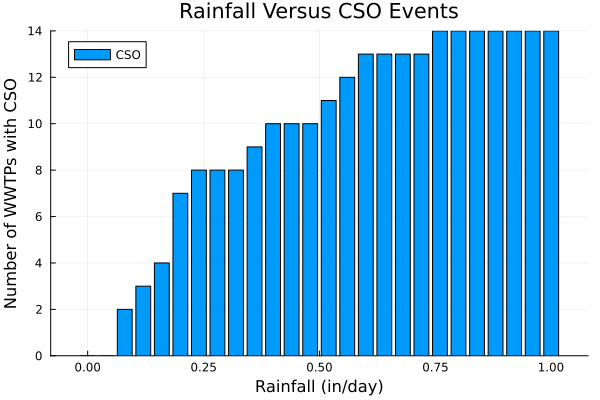

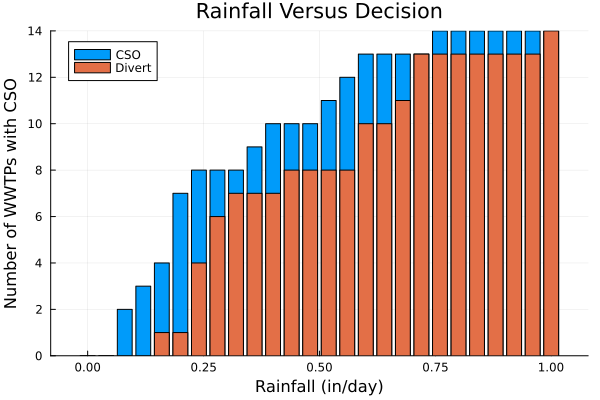

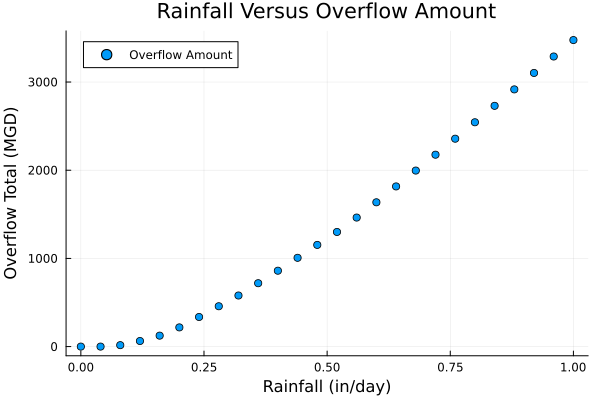

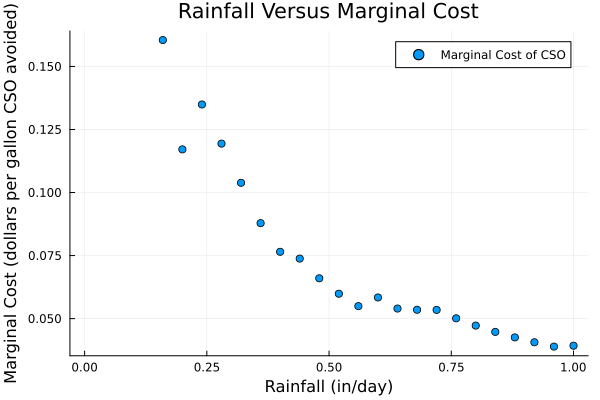

In [7]:
#rainfall vs cso events bar graph
bar_graph1 = bar(rainfall, overflow_num, label="CSO")
title!("Rainfall Versus CSO Events")
xlabel!("Rainfall (in/day)")
ylabel!("Number of WWTPs with CSO")
savefig("4750bar1.png")

#rainfall vs cso versus divert decision stacked bar graph
bar_graph2 = bar(rainfall, overflow_num, label="CSO")
bar!(rainfall, divert_num, label="Divert")
title!("Rainfall Versus Decision")
xlabel!("Rainfall (in/day)")
ylabel!("Number of WWTPs with CSO")
savefig("4750bar2.png")

#scatterplot of rainfall vs overflow amount
scatterplot = scatter(rainfall, overflow_vol, label="Overflow Amount")
title!("Rainfall Versus Overflow Amount")
xlabel!("Rainfall (in/day)")
ylabel!("Overflow Total (MGD)")
savefig("4750scatter.png")

#scatterplot of rainfall vs marginal cost
scatterplot_2 = scatter(rainfall, marginal_cost, label="Marginal Cost of CSO")
title!("Rainfall Versus Marginal Cost")
xlabel!("Rainfall (in/day)")
ylabel!("Marginal Cost (dollars per gallon CSO avoided)")
savefig("4750scatter2.png")

display(bar_graph1)
display(bar_graph2)
display(scatterplot)
display(scatterplot_2)
